# Final charts


In [111]:
import numpy as np
import torch
from typing import Literal
from safetensors.torch import load_file
import sys
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import warnings
sys.path.append("../")
from jacobian_saes.utils import load_pretrained, run_sandwich


In [112]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 8 
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8


## Histograms
Run `runners/histogram.py` first to get the data

We also plot the cumulative density function because it lets us see the differences more easily

In [113]:
model = "pythia-70m-deduped"
layer = 3

def get_hist_path(model: str, layer: int, trained_with_jac: bool = True):
    return f"../results/histograms/sae_pair_{model}_layer{layer}_16384_J{1 if trained_with_jac else 0.0}_k32:v0.safetensor"

hist_data = load_file(get_hist_path(model, layer, True))
hist = hist_data["hist"]
bin_edges = hist_data["bin_edges"]
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
hist_no_optim = load_file(get_hist_path(model, layer, False))["hist"]


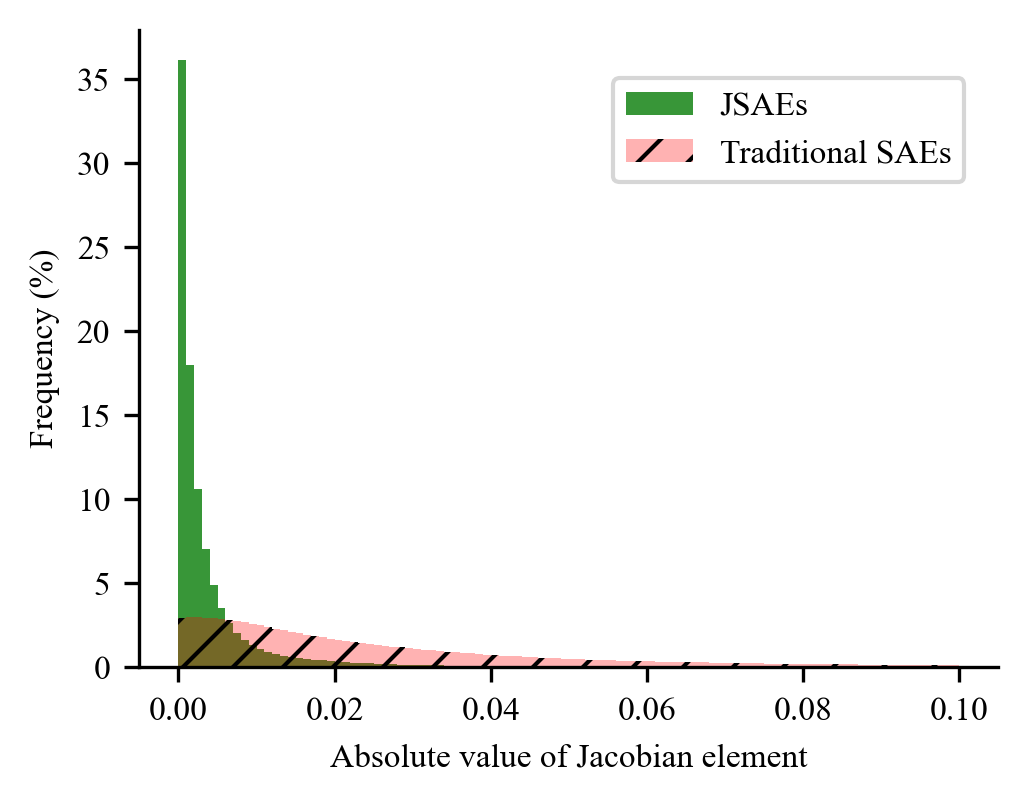

In [114]:
upper_zoom_thresh = 0.1
cropped_bin_centers = bin_centers[bin_centers < upper_zoom_thresh]
cropped_hist = hist[bin_centers < upper_zoom_thresh]
cropped_hist_no_optim = hist_no_optim[bin_centers < upper_zoom_thresh]

# Create the figure
fig, ax = plt.subplots(figsize=(3.25, 2.5), dpi=300)

# Plot the bars
width = (bin_edges[1] - bin_edges[0]).item()
ax.bar(cropped_bin_centers.cpu().numpy(), 
       cropped_hist.cpu().numpy() / hist.sum().item() * 100,
       width=width,
       color='forestgreen',
       alpha=0.9,
       label='JSAEs')

# Create hatched bars for Traditional SAEs
ax.bar(cropped_bin_centers.cpu().numpy(),
       cropped_hist_no_optim.cpu().numpy() / hist_no_optim.sum().item() * 100,
       width=width,
       color='red',
       alpha=0.3,
       hatch='//',
       label='Traditional SAEs')

# Customize the plot
ax.set_xlabel('Absolute value of Jacobian element')
ax.set_ylabel('Frequency (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize legend
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.95), fancybox=True)

# Set margins
plt.tight_layout()

plt.tight_layout(pad=0.1)

# Save the figure
plt.savefig('./charts/hist.pdf', dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()

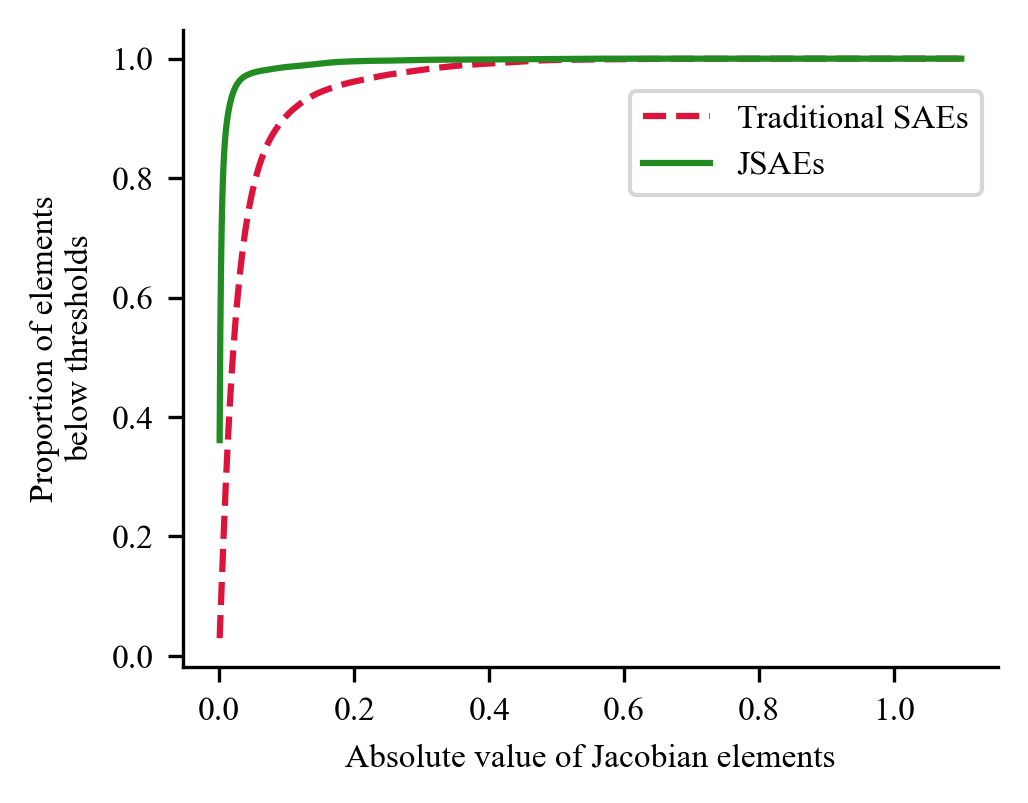

In [ ]:
cdf = hist.cumsum(dim=0) / hist.sum()
cdf_no_optim = hist_no_optim.cumsum(dim=0) / hist_no_optim.sum()

# Create figure with ICML column width
fig, ax = plt.subplots(figsize=(3.25, 2.5), dpi=300)

# Plot the lines
ax.plot(bin_centers.cpu().numpy(), 
       cdf_no_optim.cpu().numpy(),
       color='crimson',
       linestyle='--',
       label='Traditional SAEs')

ax.plot(bin_centers.cpu().numpy(),
       cdf.cpu().numpy(),
       color='forestgreen',
       linestyle='-',
       label='JSAEs')

# Customize the plot
ax.set_xlabel('Absolute value of Jacobian elements')
ax.set_ylabel('Proportion of elements\nbelow thresholds')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust legend
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.93), fancybox=True)

# Tight layout with minimal padding
plt.tight_layout(pad=0.1)

# Save the figure
plt.savefig('./charts/cdf.pdf', dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()


One figure for demonstrating sparsity with a bunch of different metrics (subcharts) incl this one

The Jacobian is generally smaller here

# Example Jacobian before and after

In [116]:
layer = 3

def get_wandb_path(layer: int, trained_with_jac: bool = True):
    return f"lucyfarnik/jsaes_pythia70m2/sae_pair_pythia-70m-deduped_layer{layer}_16384_J{1 if trained_with_jac else 0.0}_k32:v0"

sae_pair, model, mlp_with_grads, layer = load_pretrained(get_wandb_path(layer))
sae_pair_no_optim = load_pretrained(get_wandb_path(layer, False))[0]

/Users/tz20913/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Research/Jacobian SAEs/notebooks/../jacobian_saes/sae_pair.py:146: UserWarning:


This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)



Loaded pretrained model pythia-70m-deduped into HookedTransformer
Loaded pretrained model pythia-70m-deduped into HookedTransformer


In [117]:
_, cache = model.run_with_cache("Never gonna give you up", stop_at_layer=layer+1,
                                names_filter=[sae_pair.cfg.hook_name])
acts = cache[sae_pair.cfg.hook_name]
jacobian, _ = run_sandwich(sae_pair, mlp_with_grads, acts)
jacobian_no_optim, _ = run_sandwich(sae_pair_no_optim, mlp_with_grads, acts)

In [128]:
# Reshuffle (otherwise the ordering is determined by the size of the SAE latent activations which makes it look as if there's a correlation)
def shuffle_jacobian(jacobian):
    jacobian = jacobian[..., torch.randperm(jacobian.shape[-1])]
    jacobian = jacobian[..., torch.randperm(jacobian.shape[-2]), :]
    return jacobian

jacobian = shuffle_jacobian(jacobian)
jacobian_no_optim = shuffle_jacobian(jacobian_no_optim)

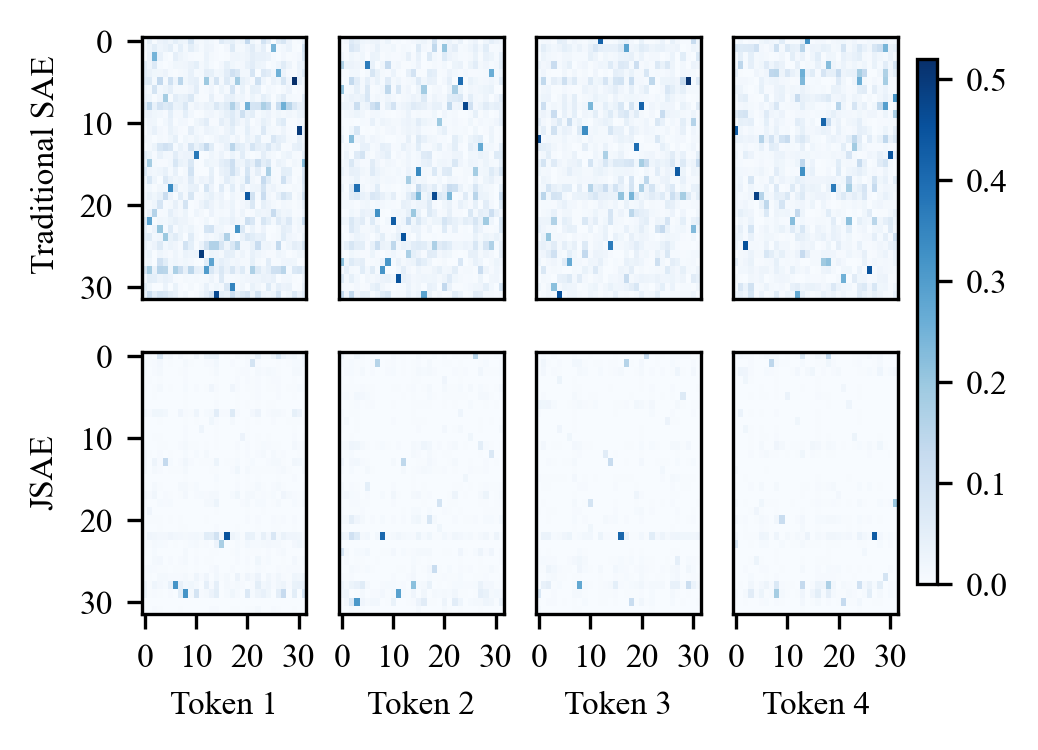

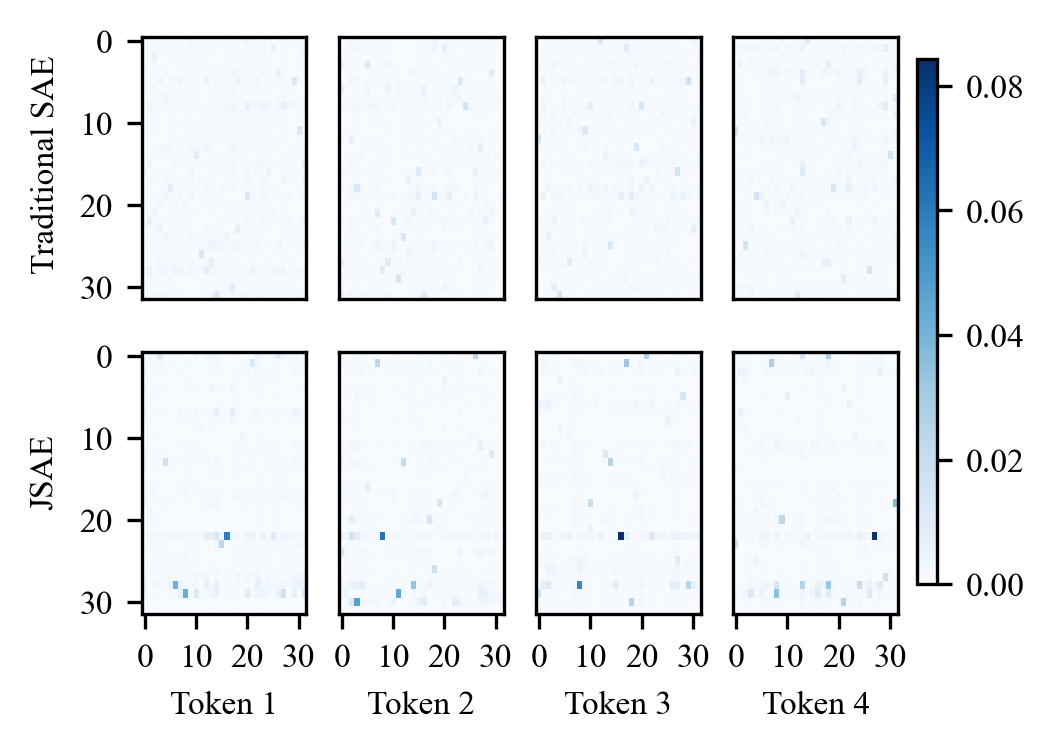

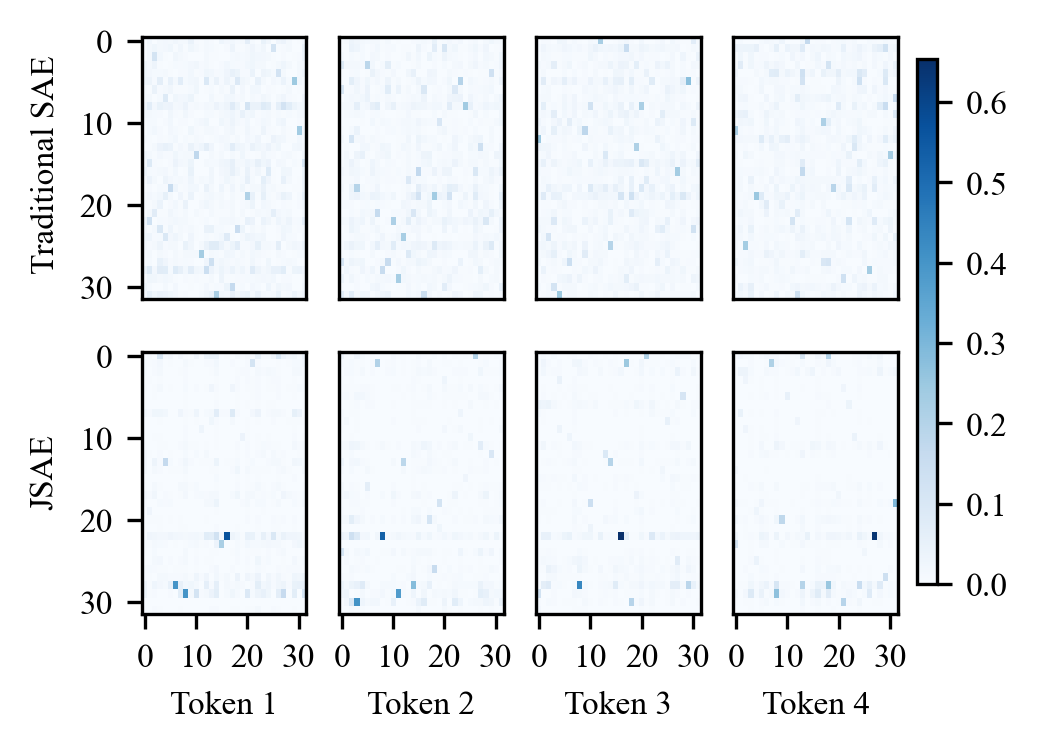

In [129]:
def plot_jacobian_examples(normalization: Literal[None, "L1", "L2"] = None):
    fig, axs = plt.subplots(2, 4, figsize=(3.25, 2.5), dpi=300)
    
    # Create common colorbar scale
    vmax = 0
    jacs = []
    jacs_no_optim = []
    for seq_pos in range(4):
        jac = jacobian[0, seq_pos+1].detach().cpu().abs().numpy()
        jac_no_optim = jacobian_no_optim[0, seq_pos+1].detach().cpu().abs().numpy()
        if normalization == "L1":
            jac /= np.abs(jac).sum()
            jac_no_optim /= np.abs(jac_no_optim).sum()
        elif normalization == "L2":
            jac /= np.sqrt(np.sum(jac**2))
            jac_no_optim /= np.sqrt(np.sum(jac_no_optim**2))
        vmax = max(vmax, max(jac.max(), jac_no_optim.max()))
        jacs.append(jac)
        jacs_no_optim.append(jac_no_optim)
    
    # Plot heatmaps
    for seq_pos, (jac, jac_no_optim) in enumerate(zip(jacs, jacs_no_optim)):
        # Plot heatmaps with consistent colorscale
        im1 = axs[0, seq_pos].imshow(jac_no_optim, cmap='Blues', aspect='auto', vmin=0, vmax=vmax)
        im2 = axs[1, seq_pos].imshow(jac, cmap='Blues', aspect='auto', vmin=0, vmax=vmax)

        # Clean up axes
        axs[0, seq_pos].set_xticks([])  # Remove x ticks from top row
        axs[0, seq_pos].set_yticks(np.arange(0, jac.shape[0], 10))
        axs[1, seq_pos].set_yticks(np.arange(0, jac.shape[0], 10))
        axs[1, seq_pos].set_xticks(np.arange(0, jac.shape[1], 10))
        
        # Only show y-axis labels for leftmost plots
        if seq_pos > 0:
            axs[0, seq_pos].set_yticks([])
            axs[1, seq_pos].set_yticks([])
    
    # Add row labels
    fig.text(0.01, 0.71, 'Traditional SAE', va='center', rotation=90)
    fig.text(0.01, 0.3, 'JSAE', va='center', rotation=90)
    
    # Add column labels
    for i in range(4):
        axs[1, i].set_xlabel(f'Token {i+1}')
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax)
    
    # Save figure
    suffix = f"_{normalization.lower()}" if normalization else ""
    plt.savefig(f'./charts/jac_example{suffix}.pdf', 
                dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


plot_jacobian_examples(), plot_jacobian_examples(normalization="L1"), plot_jacobian_examples(normalization="L2");

TODO: make sure we're only shuffling rows and cols, not just shuffling all elements

# Causal independence

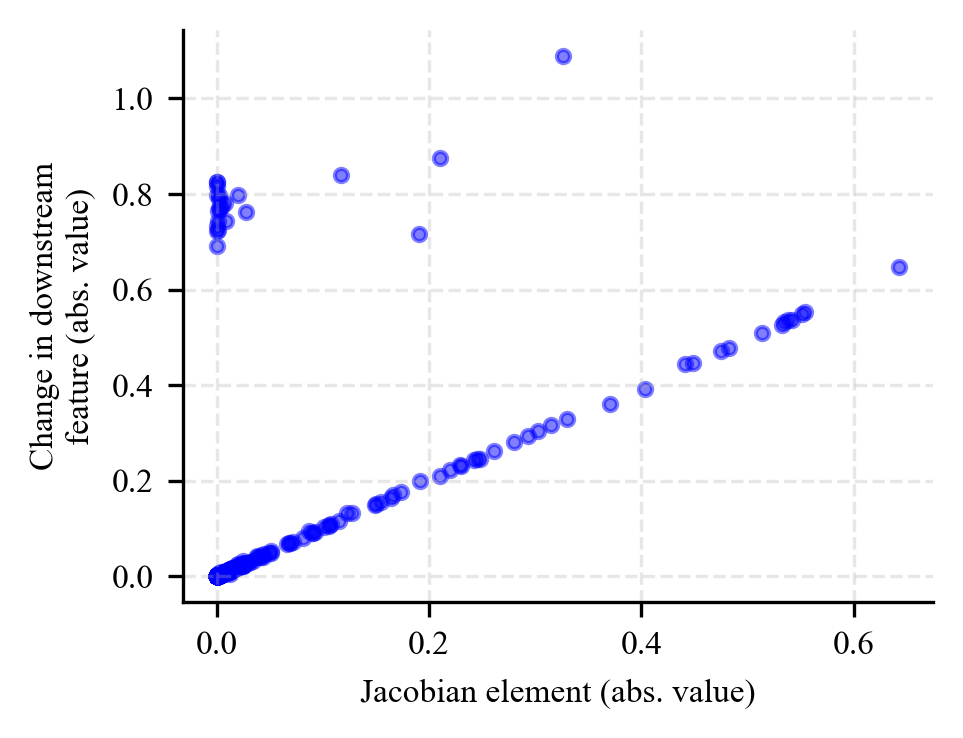

0.9749128818511963

In [126]:
take_abs = True
n_downsampled = 1_000

abl_data = load_file("../results/ablation/sae_pair_pythia-70m-deduped_layer3_16384_J1_k32:v0.safetensor")
abl_samples_full = abl_data["results"]

is_on_line = (abl_samples_full[:, 0] + abl_samples_full[:, 1]).abs() < 0.1

if take_abs:
    abl_samples_full.abs_()
    # abl_samples_no_optim.abs_()


abl_sample_small = abl_samples_full[torch.randint(0, abl_samples_full.shape[0], (n_downsampled,))]



plt.figure(figsize=(3.25, 2.5), dpi=300)

# Create scatter plot
plt.scatter(
    abl_sample_small[:, 0].cpu().numpy(),
    abl_sample_small[:, 1].cpu().numpy(),
    color='blue',
    alpha=0.5,  # Add some transparency
    s=10,  # Reduce marker size for paper
)

# Labels
plt.xlabel(f"Jacobian element{' (abs. value)' if take_abs else ''}")
plt.ylabel(f"Change in downstream\nfeature{' (abs. value)' if take_abs else ''}", multialignment='center')

# Style adjustments
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout and save
plt.tight_layout()
plt.savefig('./charts/abl_scatter.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()


is_on_line.float().mean().item()

In [121]:
is_on_line.shape

torch.Size([10000000])

chart ideas to explore this
- Laurence's idea: for each plot on this chart, sweep over the upstream feature values and plot how the downstream feature values change (so for each dot on this plot, make a line chart)


TODO: bar plot for how many examples are on the line vs in the cluster

TODO: chart where each dot is a training run where you change the jac coeff; x axis is reconstruction quality, y axis is sparsity (and also simialr stuff for autointerp et al)

TODO: figure showing that the reconstruction quality (and autointerp) doesn't suffer

# Sweeps

## Jacobian sweep

### CE loss score vs jac elements above 0.01

/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_37407/111646657.py:5: UserWarning:

You're not fetching all of the runs.





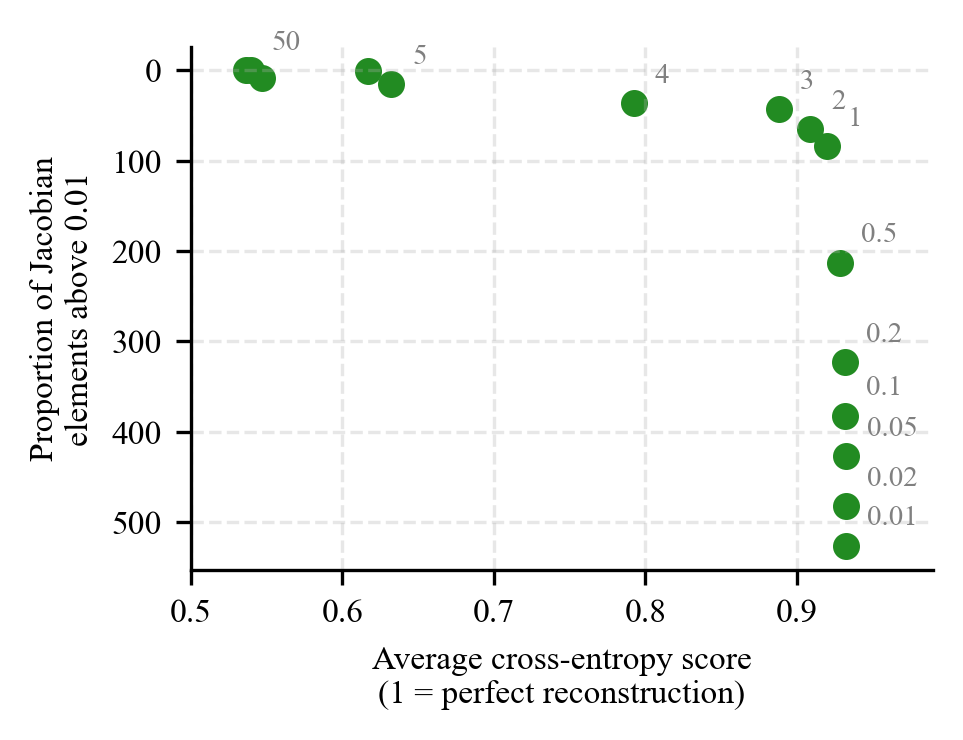

In [122]:
api = wandb.Api()
runs = api.runs("lucyfarnik/pythia70m-l3-sweep-j")

if runs.more:
    warnings.warn("You're not fetching all of the runs.\n\n")

metrics = ["jacobian_sparsity/jac_abs_above_0.01",
           "model_performance_preservation/ce_loss_score",
           "model_performance_preservation/ce_loss_score2"]

data = []
for run in runs:
    if run.state != "finished":
        warnings.warn(f"Run {run.id} is not finished.")
        continue
    run_data = {
        "jacobian_coefficient": run.config["jacobian_coefficient"],
    }
    for m in metrics:
        run_data[m.split("/")[-1]] = run.summary[m]
    data.append(run_data)

df = pd.DataFrame(data)
df["avd_ce_loss_score"] = (df["ce_loss_score"] + df["ce_loss_score2"]) / 2
# df["jac_coeff_with_label"] = df["jacobian_coefficient"].apply(lambda x: f"λ={x}")

plt.figure(figsize=(3.25, 2.5), dpi=300)

# Create scatter plot
plt.scatter(
    df["avd_ce_loss_score"],
    df["jac_abs_above_0.01"],
    color='forestgreen',
    s=30  # Marker size
)

# Add text annotations for specific values
annotate_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 50]
for _, row in df.iterrows():
    if row["jacobian_coefficient"] in annotate_values:
        jac_coef = row["jacobian_coefficient"]
        if jac_coef == int(jac_coef):
            jac_coef = int(jac_coef)

        plt.annotate(
            f'{jac_coef}',
            (row["avd_ce_loss_score"], row["jac_abs_above_0.01"]),
            xytext=(5, 5),  # Offset
            textcoords='offset points',
            fontsize=7,
            color='gray'
        )

# Customize axes
plt.xlim(0.5, 0.99)
plt.gca().invert_yaxis()  # Reverse y-axis

# Labels
plt.xlabel('Average cross-entropy score\n(1 = perfect reconstruction)', multialignment='center')
plt.ylabel('Proportion of Jacobian\nelements above 0.01', multialignment='center')

# Style adjustments
plt.grid(True, linestyle='--', alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout and save
plt.tight_layout()
plt.savefig('./charts/tradeoff_reconst_jac.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()


TODO rewrite to instead get the data from the eval runner

TODO do a bunch of these for different metrics; the more charts per unit of effort the better

TODO big grid of charts where the charts in a given row always have the same y axis and plots in the same col always have the same x axis
- These should include L1 sparsity dividied by sqrt(L2) — if those don't look as good, we might need to train with that as the objective to demonstrate that we're not just making the Jacs smaller